In [1]:
# ------------------------------------------------------------
# 0) ライブラリ & パス設定
# ------------------------------------------------------------
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np

# Excel パス
XLS_PATH = "../../data/定額制動画配信.xlsx"

# ------------------------------------------------------------
# 1) データ読み込み & 自由記述列の抽出
# ------------------------------------------------------------
xls = pd.ExcelFile(XLS_PATH)
df  = pd.read_excel(xls, sheet_name="data")



In [2]:
# ⬇️ ★ ここで自由記述列名をまとめてリスト化
FREE_COLS = ["Q3_1", "Q3_2", "Q5", "Q9"]

# テキスト前処理（欠損除去・改行削除など簡易で OK）
text_series = (
    df[FREE_COLS]
    .astype(str)
    .replace("nan", np.nan)
    .stack()          # → 1 次元にする
    .dropna()
    .str.replace(r"\s+", " ", regex=True)
    .tolist()
)



In [3]:
# ------------------------------------------------------------
# 2-A) BERT埋め込みを自前で取得（KMeans, PCA用にも使える）
# ------------------------------------------------------------
sbert_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
embeddings = sbert_model.encode(text_series, show_progress_bar=True)

# ------------------------------------------------------------
# 2-B) BERTopic を embedding_model=None で自前ベクトルを渡す
# ------------------------------------------------------------
topic_model = BERTopic(
    embedding_model=None,
    vectorizer_model=CountVectorizer(stop_words=None, ngram_range=(1, 2)),
    calculate_probabilities=True,
    verbose=False,
)
topics, probs = topic_model.fit_transform(text_series, embeddings)


# ❸ トピック上位 10 件を確認
topn = 10
topic_info = topic_model.get_topic_info().head(topn)
print(topic_info)



Batches:   0%|          | 0/420 [00:00<?, ?it/s]

   Topic  Count                                     Name  \
0     -1   2635                      -1_dtv_hbo_mcu_ncis   
1      0    670                                    0____   
2      1    410                                    1____   
3      2    294                                    2____   
4      3    226          3_cm 100_hume_spotv hume_100 25   
5      4    192   4_disney_docomo tv_disney dvd_dvd star   
6      5    155                                    5____   
7      6    133                     6_unext 25_25_unext_   
8      7    133                 7_star unext_star_unext_   
9      8    123  8_1000 hulu_netflix 1000_1000 1000_1000   

                                      Representation  \
0  [dtv, hbo, mcu, ncis, dchbo, amazon 500, sms, ...   
1                               [, , , , , , , , , ]   
2                               [, , , , , , , , , ]   
3                               [, , , , , , , , , ]   
4  [cm 100, hume, spotv hume, 100 25, 25 46, 46, ...   
5  

In [4]:
# ============【2-B) 追加：KMeans クラスタリング & 可視化】============

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns

# --- ① KMeans クラスタリング ---------------------------------
N_CLUSTERS = 6                       # ← 望むクラスタ数に調整
kmeans     = KMeans(n_clusters=N_CLUSTERS, random_state=42)
km_labels  = kmeans.fit_predict(probs)          # ❶ BERTopic の確率分布でも
# km_labels  = kmeans.fit_predict(embeddings)   # ❷ 直接 BERT 埋め込みでも OK



In [5]:
# --- ② 2 次元縮約（PCA）----------------------------------------
pca   = PCA(n_components=2, random_state=42)
XY    = pca.fit_transform(embeddings)  

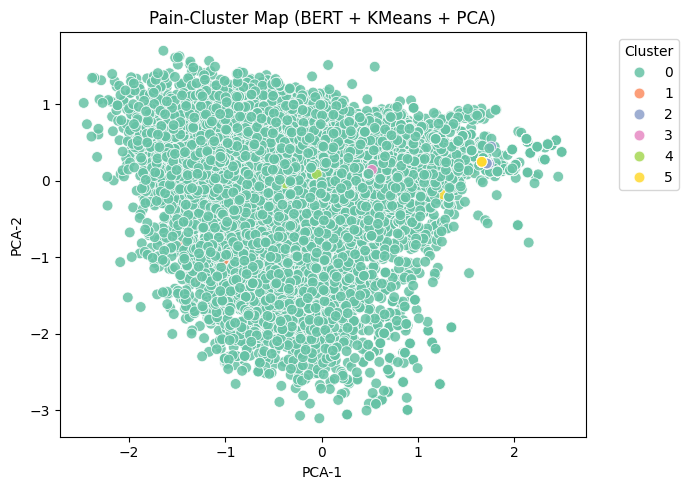


=== 代表ペイン文（クラスタ別）===


ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.

In [6]:
# --- ③ 散布図でクラスタ可視化 ----------------------------------
plt.figure(figsize=(7,5))
sns.scatterplot(x=XY[:,0], y=XY[:,1], hue=km_labels, palette="Set2", s=60, alpha=.85)
plt.title("Pain-Cluster Map (BERT + KMeans + PCA)")
plt.xlabel("PCA-1"); plt.ylabel("PCA-2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(); plt.show()

# --- ④ 代表ペイン文を抽出 --------------------------------------
df_pain = pd.DataFrame(
    {"text": text_series, "km_cluster": km_labels, "topic_id": topics}
)

rep_table = (
    df_pain
    .groupby("km_cluster")["text"]
    .apply(lambda x: x.sample(min(5, len(x))).tolist())   # 各クラスタの代表例 5 件
    .reset_index()
    .rename(columns={"text": "sample_pains"})
)
print("\n=== 代表ペイン文（クラスタ別）===")
print(rep_table.to_markdown(index=False))

# ---- ⑤: （Optional）uplift と結合 ------------------------------
# km_cluster ごとに uplift 平均を見ると ROI 高いペインが可視化できる
# merged = df.merge(df_pain, left_index=True, right_index=True, how="left")
# print(merged.groupby("km_cluster")["uplift"].mean().sort_values(ascending=False))

In [ ]:
# ------------------------------------------------------------
# 3) ペイン・ラベルを元データフレームに戻し、解析に使う
# ------------------------------------------------------------
# テキスト → topic_id のマッピング
topic_ids = pd.Series(topics, name="topic_id")
pain_df   = pd.DataFrame({"PainText": text_series}).join(topic_ids)



In [ ]:
# この pain_df と元 df を join しておけば、
# 「新サービス案がどのペインに対応しているか」を後段で検証できる
# ------------------------------------------------------------
# 4) uplift スコア計算（Q4 vs Q6 を例示）
# ------------------------------------------------------------
# アンケート列が Likert(1–10) 想定
df["base_score"] = df["Q4"]   # 既存：薦めたい度（NPS 的）
df["prop_score"] = df["Q6"]   # 新サービス：薦める可能性

# uplift = 新 - 旧
df["uplift"] = df["prop_score"] - df["base_score"]



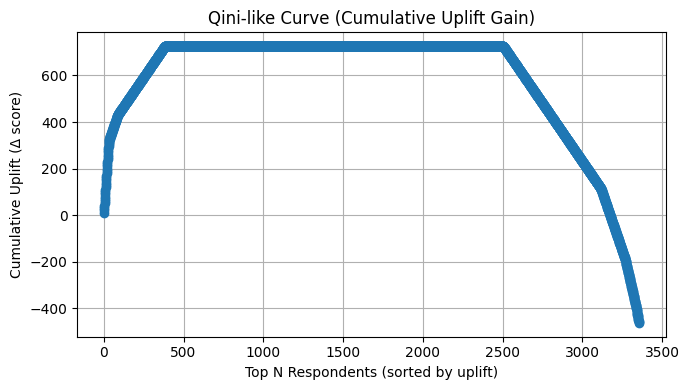

In [ ]:
# ------------------------------------------------------------
# 5) Qini 風カーブ：uplift 降順ソート → 累積効果
# ------------------------------------------------------------
df_sort = df.sort_values("uplift", ascending=False).reset_index(drop=True)
df_sort["cum_uplift"] = df_sort["uplift"].cumsum()

plt.figure(figsize=(7,4))
plt.plot(df_sort.index+1, df_sort["cum_uplift"], marker="o")
plt.title("Qini-like Curve (Cumulative Uplift Gain)")
plt.xlabel("Top N Respondents (sorted by uplift)")
plt.ylabel("Cumulative Uplift (Δ score)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 6) （任意）クラスタ別 uplift 集計で「どのペインを解決すると効果大か」を定量化
# ------------------------------------------------------------
# pain_df には topic_id が入っているので、df_sort とユーザ ID で結合し
# topic_id ごとに uplift 平均や合計を算出すると
# 「●番トピック（ペイン）を解消する新サービスが最も ROI 高い」
# という形で示せます。
#
# 例:
# merged = df.merge(pain_df, left_index=True, right_index=True, how="left")
# grouped = merged.groupby("topic_id")["uplift"].mean()
# print(grouped.sort_values(ascending=False))
